## Geneformer Embeddings

### Imports

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from env.imports import *

In [20]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run)
importlib.reload(models.train_val)
importlib.reload(data.data_utils)


<module 'data.data_utils' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/data/data_utils.py'>

#### Check job specs

In [21]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 15.1%
RAM Usage: 17.6%
Available RAM: 829.7G
Total RAM: 1007.0G
52.4G


In [22]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 1
GPU 0: NVIDIA A100-SXM4-80GB - Memory Allocated: 0.06 GB


### Setup

In [23]:
from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric
from data.data_utils import RegionPairDataset
from torch.utils.data import Subset

import anndata
from anndata import AnnData

from geneformer import TranscriptomeTokenizer
from geneformer import EmbExtractor

In [48]:
# Load data
print("Loading data...")

X_UKBB_raw, valid_genes = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, gene_list='1', sort_genes='random', impute_strategy='raw_mirror_interpolate', return_valid_genes=True)
#X_UKBB_srs, valid_genes = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, gene_list='1', sort_genes='random', impute_strategy='mirror_interpolate', return_valid_genes=True)
X_UKBB = X_UKBB_raw
Y_UKBB = load_connectome(parcellation='S456', hemisphere='both', omit_subcortical=False)
coords_UKBB = load_coords(parcellation='S456', hemisphere='both', omit_subcortical=False)
labels_UKBB, network_labels_UKBB = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices_UKBB = ~np.isnan(X_UKBB).all(axis=1)

# Create index map so we know true indices of valid data
valid_indices_values_UKBB = np.where(valid_indices_UKBB)[0]
valid2true_mapping_UKBB = dict(enumerate(valid_indices_values_UKBB))

# Subset all data using valid indices
X_UKBB_valid = X_UKBB[valid_indices_UKBB]
Y_UKBB_valid = Y_UKBB[valid_indices_UKBB][:, valid_indices_UKBB]
coords_UKBB_valid = coords_UKBB[valid_indices_UKBB]
labels_UKBB = [labels_UKBB[i] for i in range(len(labels_UKBB)) if valid_indices_UKBB[i]]
network_labels_UKBB = network_labels_UKBB[valid_indices_UKBB]

print(f"X_UKBB_valid shape: {X_UKBB_valid.shape}")

# Create dataset from X_UKBB_valid that contains each ROI as a sample
X = torch.tensor(X_UKBB_valid, dtype=torch.float32).to("cuda")
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=X_UKBB_valid.shape[0], shuffle=False)

print(X.shape)
print(X.dtype)

Loading data...
X_UKBB_valid shape: (455, 15633)
torch.Size([455, 15633])
torch.float32


In [49]:
# === Paths ===
token_dict_path = "/scratch/asr655/main_env/Geneformer/geneformer/token_dictionary_gc104M.pkl"
gene_mapping_file = "/scratch/asr655/main_env/Geneformer/geneformer/gene_name_id_dict_gc104M.pkl"

# === Load dictionaries ===
with open(token_dict_path, 'rb') as f:
    token_dict = pickle.load(f)

with open(gene_mapping_file, 'rb') as f:
    gene_mapping = pickle.load(f)

# === Check and filter valid_genes ===
if 'valid_genes' not in locals():
    raise ValueError("valid_genes is not defined")

ensembl_ids = []
gene_symbols = []
unmapped_genes = []
tokenizable_genes = []
tokenizable_ensembl_ids = []
valid_indices = []

for i, gene in enumerate(valid_genes):
    if gene in gene_mapping:
        ensembl_id = gene_mapping[gene]
        if ensembl_id in token_dict:
            gene_symbols.append(gene)
            ensembl_ids.append(ensembl_id)
            tokenizable_genes.append(gene)
            tokenizable_ensembl_ids.append(ensembl_id)
            valid_indices.append(i)
        else:
            unmapped_genes.append(gene)
    else:
        unmapped_genes.append(gene)

# === Logging ===
print(f"✅ Total input genes: {len(valid_genes)}")
print(f"✅ Mapped to Ensembl: {len(ensembl_ids)}")
print(f"✅ Tokenizable genes: {len(tokenizable_genes)}")
print(f"❌ Unmapped or untokenizable: {len(unmapped_genes)}")

# Show sample mappings
print("\n🔍 Sample HGNC → Ensembl:")
for g, eid in zip(gene_symbols[:5], ensembl_ids[:5]):
    print(f"{g} → {eid}")

print("\n🔍 Sample Ensembl ID → Token ID:")
for eid in tokenizable_ensembl_ids[:5]:
    print(f"{eid} → {token_dict[eid]}")

# === Filter expression matrix ===
X = X[:, torch.tensor(valid_indices, dtype=torch.long, device=X.device)]

print(f"\n📐 Matrix shape after filtering: {X.shape}")

✅ Total input genes: 15633
✅ Mapped to Ensembl: 14111
✅ Tokenizable genes: 14111
❌ Unmapped or untokenizable: 1522

🔍 Sample HGNC → Ensembl:
A1BG → ENSG00000121410
A2M → ENSG00000175899
A2ML1 → ENSG00000166535
A3GALT2 → ENSG00000184389
A4GALT → ENSG00000128274

🔍 Sample Ensembl ID → Token ID:
ENSG00000121410 → 5114
ENSG00000175899 → 13651
ENSG00000166535 → 11687
ENSG00000184389 → 15062
ENSG00000128274 → 5926

📐 Matrix shape after filtering: torch.Size([455, 14111])


Setup AnnData file for tokenization

In [50]:
# === Convert expression matrix to NumPy (if not already)
X_np = X.detach().cpu().numpy()
# Create dummy data with random noise for testing

# Shape matches the filtered matrix shape from above
n_cells, n_genes = X.shape

# Create synthetic data since we can't get X from GPU
#X_np = np.random.normal(loc=8.0, scale=1.5, size=(n_cells, n_genes)).astype(np.float32)


# === Create AnnData object
adata = sc.AnnData(X_np)

# === Set gene metadata (.var)
adata.var_names = pd.Index(tokenizable_ensembl_ids)  # must match token_dict keys
adata.var["gene_symbols"] = tokenizable_genes  # Use actual gene symbols
adata.var["ensembl_id"] = adata.var_names  # Store Ensembl IDs

# === Set cell metadata (.obs)
adata.obs_names = [f"cell_{i}" for i in range(adata.n_obs)]
adata.obs["filter_pass"] = True  # optional but suppresses warning in Geneformer
adata.obs["n_counts"] = adata.X.sum(axis=1)

# === Preview
print(adata)
print(adata.var.head())
print(adata.obs.head())

# === Save to disk
adata.write_h5ad("/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/ahba_pseudocounts.h5ad")

AnnData object with n_obs × n_vars = 455 × 14111
    obs: 'filter_pass', 'n_counts'
    var: 'gene_symbols', 'ensembl_id'
                gene_symbols       ensembl_id
ENSG00000121410         A1BG  ENSG00000121410
ENSG00000175899          A2M  ENSG00000175899
ENSG00000166535        A2ML1  ENSG00000166535
ENSG00000184389      A3GALT2  ENSG00000184389
ENSG00000128274       A4GALT  ENSG00000128274
        filter_pass       n_counts
cell_0         True  101050.257812
cell_1         True  100161.234375
cell_2         True  100713.171875
cell_3         True  101111.125000
cell_4         True  100537.093750


In [51]:
adata

AnnData object with n_obs × n_vars = 455 × 14111
    obs: 'filter_pass', 'n_counts'
    var: 'gene_symbols', 'ensembl_id'

In [52]:
adata.X

array([[ 8.364684 , 10.625103 ,  8.294649 , ...,  7.115774 ,  8.743466 ,
         6.6353726],
       [ 8.468622 , 10.652993 ,  8.243321 , ...,  6.990401 ,  8.632006 ,
         6.6443877],
       [ 8.219266 , 10.710257 ,  8.4102955, ...,  7.4477096,  8.828489 ,
         6.648834 ],
       ...,
       [ 8.282708 , 11.853184 ,  8.859126 , ...,  6.8847   ,  9.327422 ,
         6.874522 ],
       [ 8.367533 , 12.042262 ,  8.358485 , ...,  7.211401 ,  9.353628 ,
         6.99849  ],
       [ 8.437492 , 11.845023 ,  8.798758 , ...,  6.5930142,  9.177029 ,
         6.8638024]], dtype=float32)

In [53]:
# Load your AnnData object
adata = anndata.read_h5ad("./data/geneformer/ahba_pseudocounts.h5ad")

In [54]:
tokenizer = TranscriptomeTokenizer(
    custom_attr_name_dict=None,     # or map .obs fields like {"subject_id": "subject"} if needed
    nproc=16,                       # your HPC can handle this
    chunk_size=512,
    model_input_size=10,          # Geneformer-V2 default
    special_token=True,             # Geneformer-V2 default
    collapse_gene_ids=True,        # ❗️you've already mapped + filtered Ensembl IDs
    use_h5ad_index=True,            # ✅ your .var_names are Ensembl IDs
    keep_counts=True,              # set True if you want normalized counts kept
    model_version='V2',
    gene_median_file="/scratch/asr655/main_env/Geneformer/geneformer/gene_median_dictionary_gc104M.pkl",
    token_dictionary_file="/scratch/asr655/main_env/Geneformer/geneformer/token_dictionary_gc104M.pkl",
    gene_mapping_file="/scratch/asr655/main_env/Geneformer/geneformer/ensembl_mapping_dict_gc104M.pkl"
)

# === Tokenize data
tokenizer.tokenize_data(
    "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer",
    "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/", #ahba_tokenized.dataset",
    output_prefix="ahba",
    file_format="h5ad"
)


Tokenizing /scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/ahba_pseudocounts.h5ad
Creating dataset.


In [55]:
embex = EmbExtractor(
    model_type="Pretrained",
    num_classes=0,
    emb_mode="cell",
    #cell_emb_style="mean_pool",
    emb_layer=-1,
    #emb_label=["organ_major"],
    #labels_to_plot=["organ_major"],
    max_ncells=None,
    forward_batch_size=128,
    nproc=16,
    model_version="V2",
    token_dictionary_file="/scratch/asr655/main_env/Geneformer/geneformer/token_dictionary_gc104M.pkl"
)

In [56]:
model_path = "/scratch/asr655/main_env/Geneformer/Geneformer-V2-104M"
tokenized_data_path = "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/ahba.dataset"
output_dir = "/scratch/asr655/neuroinformatics/GeneEx2Conn/data/geneformer/embeddings"
output_prefix = 'ahba_embeddings'

embs = embex.extract_embs(
    model_directory=model_path,
    input_data_file=tokenized_data_path,
    output_directory=output_dir,
    output_prefix=output_prefix, 
    output_torch_embs=False
)

  self.comm = Comm(**args)



  0%|          | 0/4 [00:00<?, ?it/s]

In [57]:
embs

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.488595,-0.125741,-0.990202,-0.103486,-0.669662,0.151118,-0.397266,0.716433,0.636290,-0.123126,...,1.153984,0.043056,-0.097763,-0.146814,-0.633407,0.388808,0.138646,-0.201394,-0.692057,-0.364916
1,0.537412,-0.097414,-1.014553,-0.107649,-0.544234,0.136036,-0.312500,0.755484,0.556739,0.008913,...,1.067557,0.095320,-0.132017,-0.213448,-0.679009,0.332559,0.102243,-0.194798,-0.728222,-0.305206
2,0.606417,-0.040492,-1.158614,-0.190705,-0.355696,-0.024862,-0.360486,0.663498,0.486869,0.085788,...,1.266365,0.161995,-0.061905,-0.383442,-0.437376,0.621810,0.220693,-0.189819,-0.760378,-0.196861
3,0.598617,0.027037,-0.973610,-0.112107,-0.598516,0.167032,-0.325182,0.694575,0.574203,-0.012097,...,1.099473,0.056887,-0.219806,-0.182443,-0.731424,0.424145,0.161319,-0.197485,-0.636126,-0.263075
4,0.742405,-0.321046,-0.954200,0.015795,-0.581370,0.063113,-0.183246,0.497954,0.725566,0.063254,...,1.229201,0.037911,0.005074,-0.137926,-0.374526,0.473092,0.083533,-0.346635,-0.620821,-0.196008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0.625239,-0.000900,-1.030070,-0.192761,-0.438965,0.212613,-0.365760,0.511197,0.485417,-0.072793,...,1.025061,0.001698,-0.224241,-0.135641,-0.790914,0.468171,0.112362,-0.288283,-0.625742,-0.221775
451,0.468432,-0.114360,-0.947030,-0.103946,-0.530481,0.234568,-0.372352,0.609675,0.585005,0.008545,...,1.066678,-0.068921,-0.106986,-0.284800,-0.694170,0.417529,0.184963,-0.171267,-0.742438,-0.304274
452,0.611426,-0.178963,-1.031462,-0.078948,-0.551843,0.211385,-0.293282,0.665290,0.707725,0.079111,...,1.010881,0.098518,-0.097471,-0.046897,-0.461859,0.337598,-0.032790,-0.446873,-0.483978,-0.209588
453,0.532621,-0.027960,-0.982662,-0.133942,-0.500806,0.205020,-0.372435,0.682253,0.493512,0.034522,...,1.016489,0.073249,-0.160840,-0.196368,-0.813656,0.439931,0.136798,-0.203938,-0.695647,-0.231993


  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



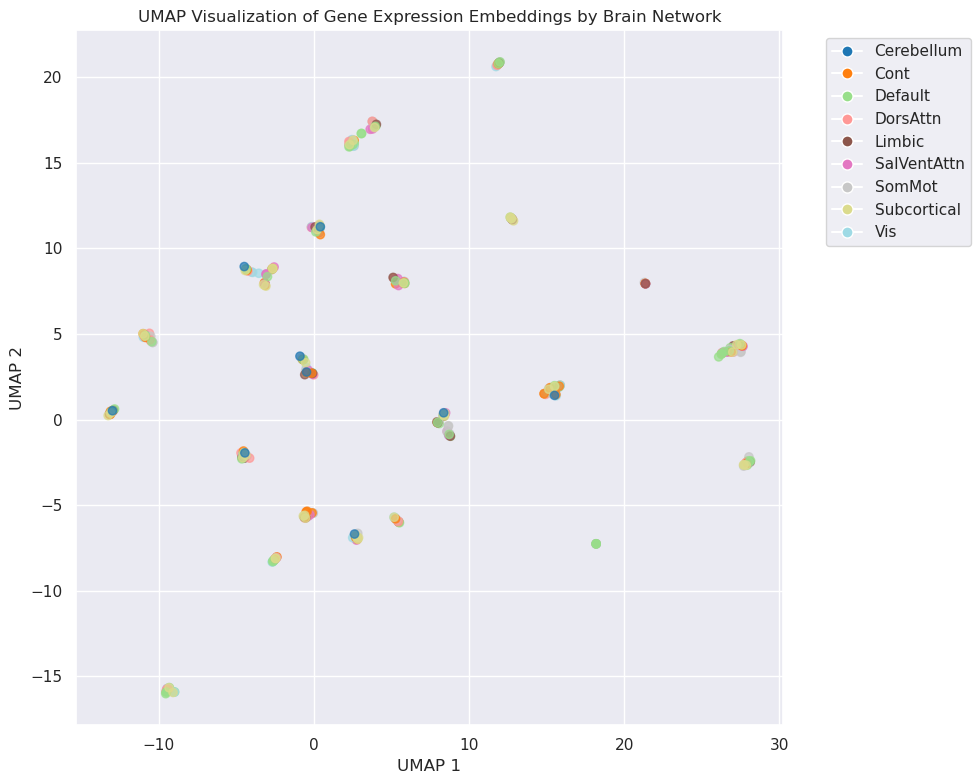

In [58]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Create UMAP reducer
reducer = umap.UMAP(random_state=42)

# Fit and transform the embeddings (excluding the organ_major column)
embedding_cols = embs.select_dtypes(include=['float64', 'float32']).columns
umap_embeddings = reducer.fit_transform(embs[embedding_cols])

# Define colors for each network
unique_networks = np.unique(network_labels_UKBB)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_networks)))
color_dict = dict(zip(unique_networks, colors))

# Create color array based on network labels
point_colors = [color_dict[label] for label in network_labels_UKBB]

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], 
                     c=point_colors, alpha=0.7)

# Add legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor=color_dict[label], label=label, markersize=8)
                  for label in unique_networks]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('UMAP Visualization of Gene Expression Embeddings by Brain Network')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
plt.show()